In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov
import csv
import glob
import seaborn as sn

# helpful character encoding module
#import chardet

## 1. Ввод данных

In [3]:
# specifying the path to csv files
path = "DATA/"
# xlsx files in the path
file_list = glob.glob(path + "/*.xlsx")
print(file_list)

['DATA\\Daily Report 2-1-2021.xlsx', 'DATA\\Daily Report 2-10-2021.XLSX', 'DATA\\Daily Report 2-11-2021.XLSX', 'DATA\\Daily Report 2-2-2021.xlsx', 'DATA\\Daily Report 2-3-2021.XLSX', 'DATA\\Daily Report 2-4-2021.XLSX', 'DATA\\Daily Report 2-5-2021.XLSX', 'DATA\\Daily Report 2-6-2021.XLSX', 'DATA\\Daily Report 2-7-2021.XLSX', 'DATA\\Daily Report 2-8-2021.XLSX', 'DATA\\Daily Report 2-9-2021.XLSX']


In [4]:
excl_list = []
for file in file_list:
    df = pd.read_excel(file, sheet_name='Daily', usecols="A:R", skiprows=0,nrows=5760, header = 0)
    df = pd.DataFrame(df) #преобразование в датафрейм
    df[["Date","Time"]]=df[["Date","Time"]].astype(str) #присвоение строкам типа "строка"
    df['timestamp']=pd.to_datetime(df.Date + ' ' + df.Time) #создание колонки с типом данных datetime
    df_changed=df #создание нового датафрейма
    df_changed.drop(['Date','Time'], inplace=True, axis=1) #убрать колонки Date and Time
    titles=list(df_changed.columns)
    titles[0],titles[16]=titles[16],titles[0] # смена порядка колонок
    df_changed=df_changed[titles]
    excl_list.append(df_changed)#добавляем новый элементв в конец
excl_merged = pd.concat(excl_list, axis=0, ignore_index=False) #конкатенация всех листов
excl_merged.sort_values(by='timestamp', inplace=True) #сортировка по timeseries в порядке возрастания
excl_merged.set_index('timestamp', inplace=True) # set column 'date' to index
excl_merged.head(4)

,Hydraulic BAR Pressure bar,Current Curve Selected,Bowl Speed RPM RPM,Differential Speed RPM,Sludge Flow m3h,Centrifuge Vibration mm/sec,Solids End Bearing Temp Â°C,Liquid End Bearing Temp Â°C,SCI Scale Weight,SCI Scale Totalizer,Diverter Open %,Lube Flow Solid End,Lube Flow Liquid A,Lube Flow Liquid B,Hydraulic Temp,Bowl Speed %
timestamp,,,,,,,,,,,,,,,,
2021-02-01 00:00:00,78.531898,1,1711,11.932508,86.082176,1.867694,76.106628,82.533424,9.548612,51010,100.0,91.634109,100.025322,92.494934,52.535667,69
2021-02-01 00:00:15,87.131073,1,1786,12.011719,38.682724,3.063368,76.118706,82.527382,7.646484,51010,100.0,91.116898,100.047012,92.715569,52.535667,72
2021-02-01 00:00:30,87.131073,1,1786,12.011719,38.682724,3.063368,76.118706,82.527382,7.646484,51010,100.0,91.116898,100.047012,92.715569,52.535667,72
2021-02-01 00:00:45,79.038269,1,1740,11.949870,363.299347,2.782335,76.118706,82.551537,7.327474,51010,100.0,90.917969,100.025322,92.661316,52.535667,70


In [5]:
excl_merged.to_excel('DATA_EXPORT/Total.xlsx', index = False)   

## 2. Обработка данных (очистка, поиск аномалий)

### 2.1. Добавить дни и часы

In [6]:
data_for_analysis=excl_merged
data_for_analysis['day'] = excl_merged.index.day
data_for_analysis['hour'] = excl_merged.index.hour
data_for_analysis['day'] = excl_merged.index.day
data_for_analysis['day_of_week'] = excl_merged.index.dayofweek

### 2.2. Очистка данных

In [7]:
data_for_analysis.dtypes #типы данных в колонках

Hydraulic BAR Pressure bar     float64
Current Curve Selected           int64
Bowl Speed RPM RPM               int64
Differential Speed RPM         float64
Sludge Flow m3h                float64
Centrifuge Vibration mm/sec    float64
Solids End Bearing Temp Â°C    float64
Liquid End Bearing Temp Â°C    float64
SCI Scale Weight               float64
SCI Scale Totalizer              int64
Diverter Open %                float64
Lube Flow Solid End            float64
Lube Flow Liquid A             float64
Lube Flow Liquid B             float64
Hydraulic Temp                 float64
Bowl Speed %                     int64
day                              int64
hour                             int64
day_of_week                      int64
dtype: object

In [8]:
data_for_analysis.shape #размеры массива

(63360, 19)

In [9]:
#f. Do any of the rows have missing values?
missing_values_count = data_for_analysis.isnull().sum()

In [10]:
# how many total missing values do we have?
total_cells = np.product(data_for_analysis.shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.0


In [11]:
#параметры массива данных
data_for_analysis.describe()

,Hydraulic BAR Pressure bar,Current Curve Selected,Bowl Speed RPM RPM,Differential Speed RPM,Sludge Flow m3h,Centrifuge Vibration mm/sec,Solids End Bearing Temp Â°C,Liquid End Bearing Temp Â°C,SCI Scale Weight,SCI Scale Totalizer,Diverter Open %,Lube Flow Solid End,Lube Flow Liquid A,Lube Flow Liquid B,Hydraulic Temp,Bowl Speed %,day,hour,day_of_week
count,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000
mean,55.932038,1.142456,1542.368513,11.495320,309.131000,3.040116,71.440598,78.925276,6.174419,51800.970123,87.999865,84.098867,90.638792,83.489351,50.452002,61.965025,6.000000,11.500000,2.454545
std,29.729471,0.989538,519.970458,5.130141,173.074143,1.677993,12.301002,13.761031,4.685397,989.404571,31.797132,26.953917,28.962161,26.695553,5.835391,20.906725,3.162303,6.922241,1.876357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.028935,-0.043403,0.000000,0.000000,1.000000,0.000000,0.000000
25%,36.250359,1.000000,1719.000000,9.946832,223.867905,2.157190,74.415367,82.189125,2.508681,51402.000000,100.000000,90.049911,99.956596,91.312210,47.679108,69.000000,3.000000,5.750000,1.000000
50%,62.084057,1.000000,1720.000000,12.009549,425.817444,2.983941,75.490524,83.524010,5.896267,51798.000000,100.000000,92.078995,99.989151,91.822197,49.815788,69.000000,6.000000,11.500000,2.000000
75%,72.740345,1.000000,1724.000000,12.012804,438.024475,3.813730,76.577759,84.309242,8.905165,52241.000000,100.000000,94.205734,100.018082,92.386429,52.339592,69.000000,9.000000,17.250000,4.000000
max,194.137009,8.000000,1803.000000,20.515408,500.000000,50.000000,77.979088,86.900497,29.998915,52617.000000,100.000000,100.437637,100.249565,100.061485,64.003357,73.000000,11.000000,23.000000,6.000000


### 2.2. Scaling and normalization

In [12]:
# for Box-Cox Transformation
from scipy import stats
# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

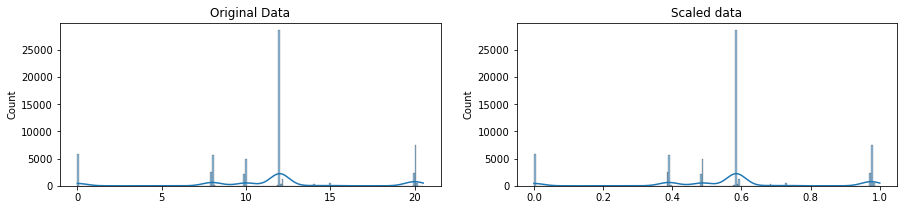

In [13]:
# mix-max scale the data between 0 and 1
original_data=data_for_analysis["Differential Speed RPM"].to_numpy() #переводим в array для корректной работы
scaled_data = minmax_scaling(original_data, columns=[0])
# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sn.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sn.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

In [14]:
#Copy the strictly positive data to posdata
posdata = original_data[original_data > 0]
posdata

array([11.93250847, 12.01171875, 12.01171875, ...,  9.9468317 ,
        9.9468317 ,  9.9468317 ])

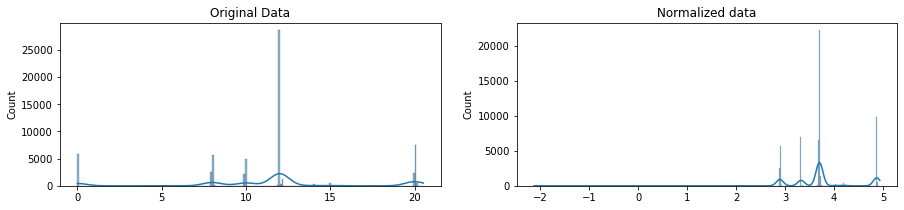

In [15]:
# normalize the exponential data with boxcox
normalized_data = stats.boxcox(posdata)
# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sn.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sn.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data")
plt.show()

## 2. Визуализация массива данных

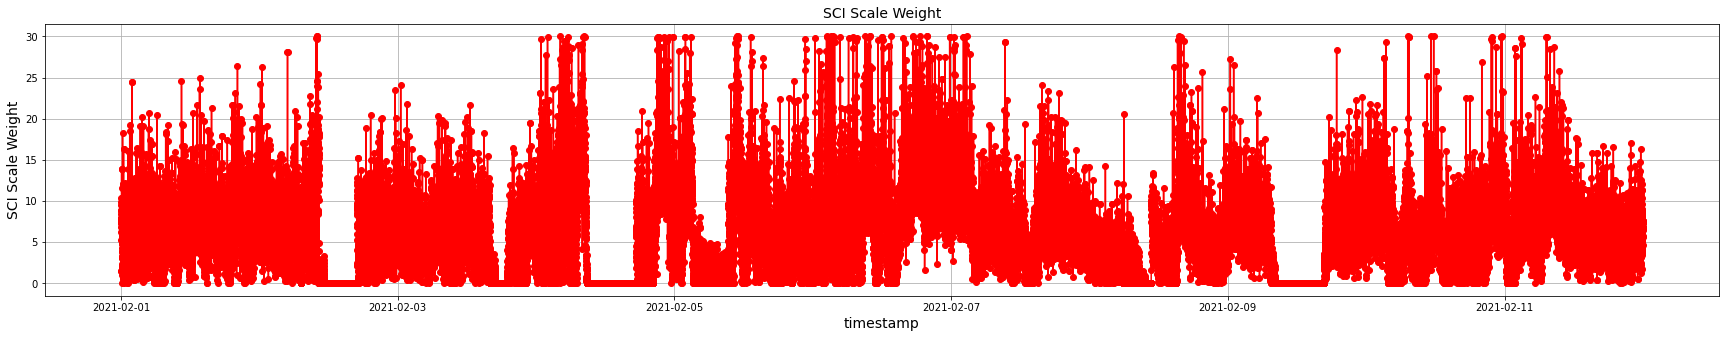

In [16]:
plt.figure(figsize=(30, 5))
plt.plot(data_for_analysis.index, data_for_analysis['SCI Scale Weight'], color='red', marker='o')
plt.title('SCI Scale Weight', fontsize=14)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('SCI Scale Weight', fontsize=14)
plt.grid(True)
plt.show()

<AxesSubplot:xlabel='timestamp', ylabel='SCI Scale Weight'>

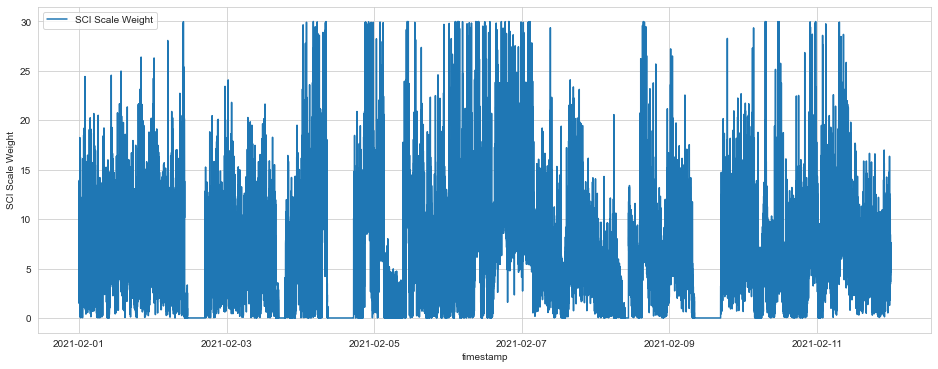

In [17]:
# Change the style of the figure
sn.set_style("whitegrid") #"darkgrid", "whitegrid", "dark", "white", "ticks"

# Set the width and height of the figure
plt.figure(figsize=(16,6))

# Line chart 
sn.lineplot(data=data_for_analysis['SCI Scale Weight'], label="SCI Scale Weight")

In [34]:
!pip install -U -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [47]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf

cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
pd.options.display.max_rows = 30
pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [48]:
import os
from IPython.display import Image, display, HTML

In [49]:
df = data_for_analysis
df.head()

,Hydraulic BAR Pressure bar,Current Curve Selected,Bowl Speed RPM RPM,Differential Speed RPM,Sludge Flow m3h,Centrifuge Vibration mm/sec,Solids End Bearing Temp Â°C,Liquid End Bearing Temp Â°C,SCI Scale Weight,SCI Scale Totalizer,Diverter Open %,Lube Flow Solid End,Lube Flow Liquid A,Lube Flow Liquid B,Hydraulic Temp,Bowl Speed %,day,hour,day_of_week
timestamp,,,,,,,,,,,,,,,,,,,
2021-02-01 00:00:00,78.531898,1,1711,11.932508,86.082176,1.867694,76.106628,82.533424,9.548612,51010,100.0,91.634109,100.025322,92.494934,52.535667,69,1,0,0
2021-02-01 00:00:15,87.131073,1,1786,12.011719,38.682724,3.063368,76.118706,82.527382,7.646484,51010,100.0,91.116898,100.047012,92.715569,52.535667,72,1,0,0
2021-02-01 00:00:30,87.131073,1,1786,12.011719,38.682724,3.063368,76.118706,82.527382,7.646484,51010,100.0,91.116898,100.047012,92.715569,52.535667,72,1,0,0
2021-02-01 00:00:45,79.038269,1,1740,11.949870,363.299347,2.782335,76.118706,82.551537,7.327474,51010,100.0,90.917969,100.025322,92.661316,52.535667,70,1,0,0
2021-02-01 00:01:00,86.344398,1,1765,12.011719,25.426794,1.766565,76.106628,82.557579,8.840061,51010,100.0,91.276047,100.018082,92.209206,52.540695,71,1,0,0


# Simple Widgets

In [50]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [57]:
@interact
def show_timestamps_more_than(column='Differential Speed RPM', x=10):
    display(HTML(f'<h2>Showing timestamps with more than {x} {column}<h2>'))
    display(df.loc[df[column] > x, ['Differential Speed RPM', 'Sludge Flow m3h', 'SCI Scale Weight']])

,Differential Speed RPM,Sludge Flow m3h,SCI Scale Weight
timestamp,,,
2021-02-01 00:00:00,11.932508,86.082176,9.548612
2021-02-01 00:00:15,12.011719,38.682724,7.646484
2021-02-01 00:00:30,12.011719,38.682724,7.646484
2021-02-01 00:00:45,11.949870,363.299347,7.327474
2021-02-01 00:01:00,12.011719,25.426794,8.840061
...,...,...,...
2021-02-11 23:58:00,10.023872,443.829559,6.869575
2021-02-11 23:58:15,10.023872,443.829559,6.869575
2021-02-11 23:58:30,10.023872,444.245514,7.376302


In [53]:
@interact
def scatter_plot(x=list(df.select_dtypes('number').columns), 
                 y=list(df.select_dtypes('number').columns)[1:],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    
    df.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='title',
             title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

KeyError: 'title'

## Библиотека bokeh

In [18]:
#импорт библиотеки bokeh
from bokeh.layouts import column
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar

In [19]:
output_notebook() #нужно, чтобы печатать прямо в блокнот

Loading BokehJS ...

In [20]:
# create a new plot with a datetime axis type
TOOLTIPS = [
    ("(SCI Scale Weight)", "($y)"),
    ]
p = figure(width=800, height=250,tooltips=TOOLTIPS, x_axis_type="datetime", background_fill_color="white", plot_height = 400, plot_width = 1600)
p.title.text = 'Click on legend entries to hide the corresponding lines'

p.line(data_for_analysis.index, data_for_analysis['SCI Scale Weight'], color='navy', alpha=0.5)
#p.legend.location = "top_left"
#p.legend.click_policy="hide"
#output_file("barchart.html", title="barchart")
show(p)

<AxesSubplot:xlabel='Differential Speed RPM', ylabel='SCI Scale Weight'>

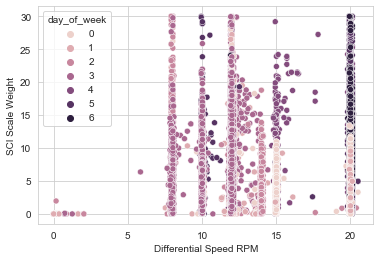

In [21]:
#scatterplot кластеризующий по признаку дня недели
sn.scatterplot(x=data_for_analysis['Differential Speed RPM'], y=data_for_analysis['SCI Scale Weight'], hue=data_for_analysis['day_of_week'])

<AxesSubplot:>

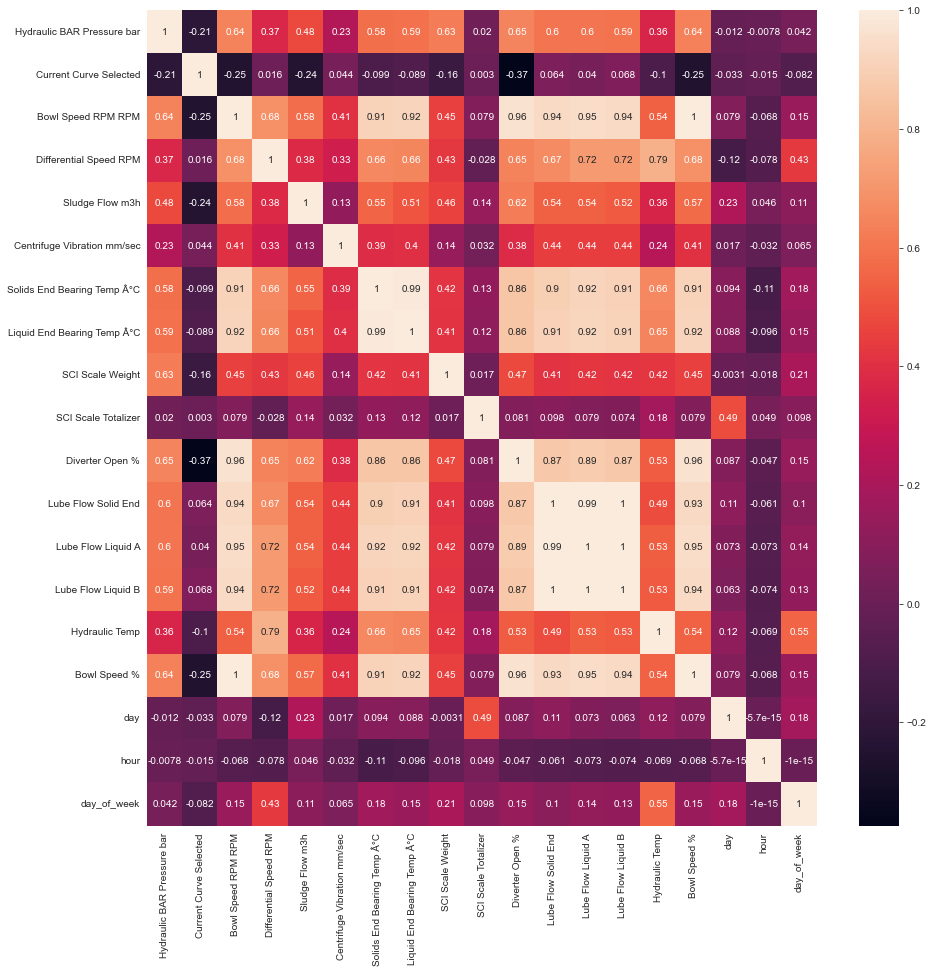

In [22]:
plt.figure(figsize=(15, 15))
corr=data_for_analysis
corrMatrix = corr.corr()
#corrMatrix.style.background_gradient(cmap='coolwarm')
sn.heatmap(corrMatrix, annot=True)
#plt.show()

## Linear regression

In [23]:
from sklearn.linear_model import LinearRegression

ML_data = data_for_analysis.copy()

ML_data['Time'] = np.arange(len(ML_data.index))

# Training data
X = ML_data.loc[:, ['Time']]  # features
y = ML_data.loc[:, 'Differential Speed RPM']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


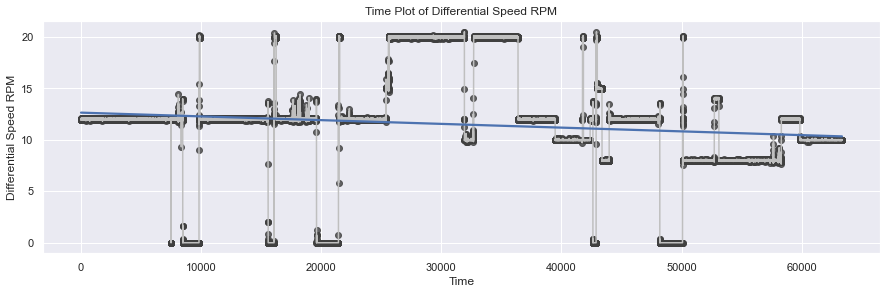

In [24]:
sn.set(rc={'figure.figsize':(15,4.27)})
fig, ax = plt.subplots()
ax.plot('Time', 'Differential Speed RPM', data=ML_data, color='0.75')
ax = sn.regplot(x='Time', y='Differential Speed RPM', data=ML_data, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Differential Speed RPM');

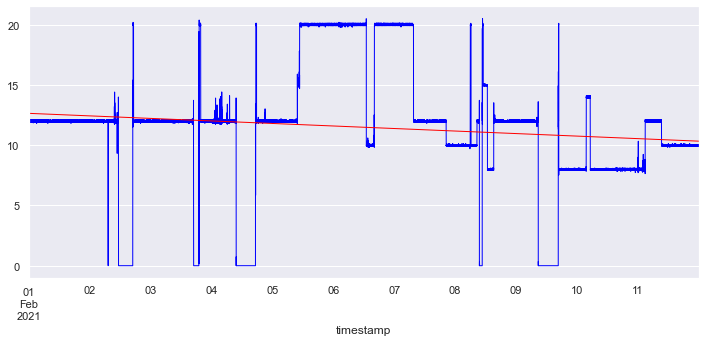

In [31]:
plt.figure(figsize=(12,5))
plt.xlabel('timestamp')
ax1 = y.plot(color='blue', grid=True, label='Fact', linewidth=1)
ax2 = y_pred.plot(color='red', grid=True, label='predict', linewidth=1)
plt.show()

In [33]:
X = ML_data.out_of_sample(steps=30)  # features

AttributeError: 'DataFrame' object has no attribute 'out_of_sample'

# Filling in missing values automatically

In [ ]:
# replace all NA's with 0
subset_nfl_data.fillna(0)

# replace all NA's the value that comes directly after it in the same column, 
# then replace all the remaining na's with 0
subset_nfl_data.fillna(method='bfill', axis=0).fillna(0)

### Inconsistent Data Entry

In [ ]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()
# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

In [19]:
#We're going to use the fuzzywuzzy package to help identify which strings are closest to each other. This dataset is small enough that we could probably could correct errors by hand, but that approach doesn't scale well. (Would you want to correct a thousand errors by hand? What about ten thousand? Automating things as early as possible is generally a good idea. Plus, it’s fun!)
# get the top 10 closest matches to "south korea"
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

NameError: name 'fuzzywuzzy' is not defined

In [ ]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")